<a href="https://colab.research.google.com/github/hemantkashniyal/EVA4/blob/master/notebooks/EVA4_Session_5_File2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target
Reduce network parameters 

# Result
Parameters: 9.6k

Best Train Accuracy: 12.41

Best Test Accuracy: 11.35

# Analysis
Reduced network parameters to 9.6k but accuracy crashed to lowest point

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


import random 
import numpy as np


def reset_seed(seed_value=1):
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)

  cuda = torch.cuda.is_available()
  print("CUDA Available?", cuda)
  if cuda:
      torch.cuda.manual_seed(seed_value)

  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# Normalize Experiment

In [2]:
def get_mean_std(data_type, exp):
  exp_data = exp.data.numpy()
  exp_data = exp.transform(exp_data)

  print('[{}]'.format(data_type))
  print(' - Numpy Shape:', exp.data.cpu().numpy().shape)
  print(' - Tensor Shape:', exp.data.size())
  print(' - min:', torch.min(exp_data))
  print(' - max:', torch.max(exp_data))
  print(' - mean:', torch.mean(exp_data))
  print(' - std:', torch.std(exp_data))
  print(' - var:', torch.var(exp_data))

  data_mean = torch.mean(exp_data).item()
  print("{} data_mean: {}".format(data_type, data_mean))

  data_std = torch.std(exp_data).item()
  print("{} data_std: {}".format(data_type, data_std))

  return data_mean, data_std

# simple transform
simple_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.ToPILImage(),
                                      transforms.Resize((28, 28)),
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      ])
reset_seed()
train = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=simple_transforms)

train_data_mean, train_data_std = get_mean_std("Train", train)
test_data_mean, test_data_std = get_mean_std("Test", test)

CUDA Available? True
[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(0.3608)
 - mean: tensor(0.1213)
 - std: tensor(0.1176)
 - var: tensor(0.0138)
Train data_mean: 0.12131021171808243
Train data_std: 0.11762356013059616
[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - min: tensor(0.)
 - max: tensor(0.3765)
 - mean: tensor(0.1232)
 - std: tensor(0.1238)
 - var: tensor(0.0153)
Test data_mean: 0.12320266664028168
Test data_std: 0.12376203387975693


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose(
                                      simple_transforms.transforms + [
                                      transforms.Normalize((train_data_mean,), (train_data_std,))
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.ToPILImage(),
                                      transforms.Resize((28, 28)),
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((train_data_mean,), (train_data_std,))
                                      ])


# Dataset and Creating Train/Test Split

In [4]:
reset_seed()
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

CUDA Available? True


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
reset_seed()

cuda = torch.cuda.is_available()

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

## Training Data

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-1.0313)
 - max: tensor(2.0359)
 - mean: tensor(-1.1333e-07)
 - std: tensor(1.)
 - var: tensor(1.)
torch.Size([512, 1, 28, 28])
torch.Size([512])


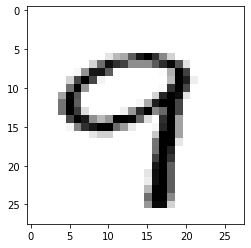

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


### MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

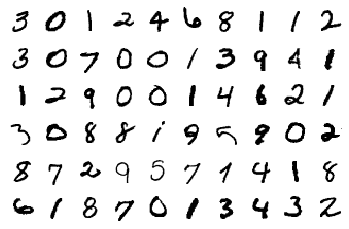

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Test Data

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - min: tensor(-1.0313)
 - max: tensor(2.1693)
 - mean: tensor(0.0161)
 - std: tensor(1.0522)
 - var: tensor(1.1071)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([512, 1, 28, 28])
torch.Size([512])


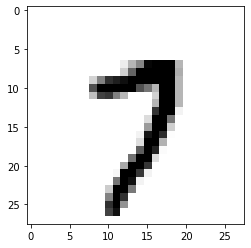

In [8]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
test_data = test.test_data
test_data = test.transform(test_data.numpy())

print('[Test]')
print(' - Numpy Shape:', test.test_data.cpu().numpy().shape)
print(' - Tensor Shape:', test.test_data.size())
print(' - min:', torch.min(test_data))
print(' - max:', torch.max(test_data))
print(' - mean:', torch.mean(test_data))
print(' - std:', torch.std(test_data))
print(' - var:', torch.var(test_data))

dataiter = iter(test_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


### MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

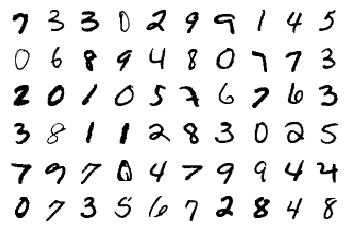

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
bias_bool = True
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        out_channels = 8
        self.convblock0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=bias_bool),
            nn.ReLU(),
        ) # output_size = 28 RF = 3

        # CONVOLUTION BLOCK 1
        in_channel = out_channels
        out_channels = 8
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=bias_bool),
            nn.ReLU(),
        ) # output_size = 28 RF = 5

        # TRANSITION BLOCK 1
        in_channel = out_channels
        out_channels = 16
        self.transition1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(1, 1), padding=1, bias=bias_bool),
            nn.ReLU(),
        ) # output_size = 28 RF = 5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14 RF = 10

        # CONVOLUTION BLOCK 2
        in_channel = out_channels
        out_channels = 16
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=bias_bool),
            nn.ReLU(),
        ) # output_size = 14 RF = 12

        # CONVOLUTION BLOCK 3
        in_channel = out_channels
        out_channels = 16
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=bias_bool),
            nn.ReLU(),
        ) # output_size = 14 RF = 14

        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 7 RF = 28

        # CONVOLUTION BLOCK 4
        in_channel = out_channels
        out_channels = 14
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(3, 3), padding=0, bias=bias_bool),
            nn.ReLU(),
        ) # output_size = 5 RF = 30

        # CONVOLUTION BLOCK 5
        in_channel = out_channels
        out_channels = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(3, 3), padding=0, bias=bias_bool),
            nn.ReLU(),
        ) # output_size = 3 RF = 32

        # CONVOLUTION BLOCK 6
        in_channel = out_channels
        out_channels = 10
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=(3, 3), padding=0, bias=bias_bool),
        ) # output_size = 1 RF = 34

        self.gap = nn.AvgPool2d(1)

    def forward(self, x):
        x = self.convblock0(x)
        x = self.convblock1(x)
        x = self.transition1(x)
        x = self.pool1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool2(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [11]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             584
              ReLU-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 30, 30]             144
              ReLU-6           [-1, 16, 30, 30]               0
         MaxPool2d-7           [-1, 16, 15, 15]               0
            Conv2d-8           [-1, 16, 15, 15]           2,320
              ReLU-9           [-1, 16, 15, 15]               0
           Conv2d-10           [-1, 16, 15, 15]           2,320
             ReLU-11           [-1, 16, 15, 15]               0
        MaxPool2d-12             [-1, 16, 7, 7]               0
           Conv2d-13             [-1, 14, 5, 5]           2,030
             ReLU-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [13]:
reset_seed()

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/118 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 0


Loss=2.29196834564209 Batch_id=117 Accuracy=12.41: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3016, Accuracy: 1135/10000 (11.35%)

EPOCH: 1


Loss=2.3050382137298584 Batch_id=117 Accuracy=11.24: 100%|██████████| 118/118 [00:23<00:00,  5.07it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3013, Accuracy: 1135/10000 (11.35%)

EPOCH: 2


Loss=2.2947351932525635 Batch_id=117 Accuracy=11.24: 100%|██████████| 118/118 [00:23<00:00,  5.07it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3017, Accuracy: 1135/10000 (11.35%)

EPOCH: 3


Loss=2.3034794330596924 Batch_id=117 Accuracy=11.14: 100%|██████████| 118/118 [00:23<00:00,  5.08it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3012, Accuracy: 1135/10000 (11.35%)

EPOCH: 4


Loss=2.300631284713745 Batch_id=117 Accuracy=11.24: 100%|██████████| 118/118 [00:23<00:00,  5.08it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3014, Accuracy: 1135/10000 (11.35%)

EPOCH: 5


Loss=2.3102591037750244 Batch_id=117 Accuracy=11.15: 100%|██████████| 118/118 [00:23<00:00,  5.11it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3015, Accuracy: 1135/10000 (11.35%)

EPOCH: 6


Loss=2.3093512058258057 Batch_id=117 Accuracy=11.18: 100%|██████████| 118/118 [00:23<00:00,  5.02it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3013, Accuracy: 1135/10000 (11.35%)

EPOCH: 7


Loss=2.303781747817993 Batch_id=117 Accuracy=11.24: 100%|██████████| 118/118 [00:23<00:00,  5.13it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3013, Accuracy: 1135/10000 (11.35%)

EPOCH: 8


Loss=2.2962300777435303 Batch_id=117 Accuracy=11.11: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3013, Accuracy: 1135/10000 (11.35%)

EPOCH: 9


Loss=2.2974536418914795 Batch_id=117 Accuracy=11.17: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3019, Accuracy: 1135/10000 (11.35%)

EPOCH: 10


Loss=2.297349691390991 Batch_id=117 Accuracy=11.13: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3018, Accuracy: 1010/10000 (10.10%)

EPOCH: 11


Loss=2.3010599613189697 Batch_id=117 Accuracy=11.12: 100%|██████████| 118/118 [00:22<00:00,  5.26it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3013, Accuracy: 1135/10000 (11.35%)

EPOCH: 12


Loss=2.2950356006622314 Batch_id=117 Accuracy=11.14: 100%|██████████| 118/118 [00:22<00:00,  5.30it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3013, Accuracy: 1135/10000 (11.35%)

EPOCH: 13


Loss=2.308192253112793 Batch_id=117 Accuracy=11.24: 100%|██████████| 118/118 [00:22<00:00,  5.36it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)

EPOCH: 14


Loss=2.305992364883423 Batch_id=117 Accuracy=11.24: 100%|██████████| 118/118 [00:21<00:00,  5.44it/s]



Test set: Average loss: 2.3014, Accuracy: 1135/10000 (11.35%)



Text(0.5, 1.0, 'Test Accuracy')

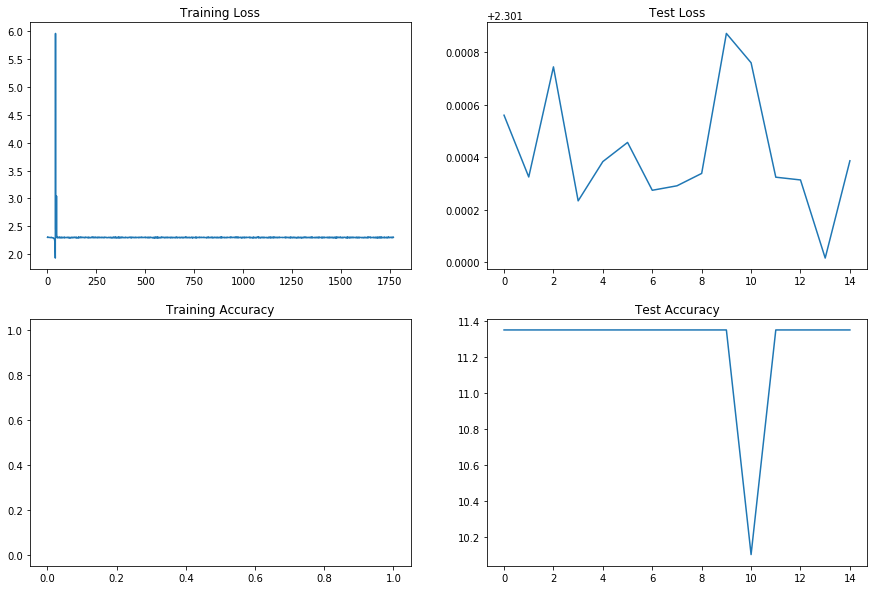

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")